# Supplemental Models (K-Means Clustering)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Spacy
import spacy

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# NLTK
from nltk.corpus import stopwords

# Silence Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
blush = '#F7D1CD'
medium_purple = '#B392AC'
dark_purple = '#B392AC'
warm_grey = '#8E9AAF'

## Read-In Data

In [3]:
health = pd.read_csv('../data/womens_health_preprocessed.csv', lineterminator='\n')
print(f'Health: {health.shape}')
obsgyn = pd.read_csv('../data/fertility_and_pregnancy_preprocessed.csv')
print(f'ObsGyn: {obsgyn.shape}')

Health: (30616, 7)
ObsGyn: (92943, 7)


## Model Preparation

### Create Document Term Matrix From Corpus

In order to convert each document (post) in the corpus to a vector, I will use ***Sklearn***'s `TfidfVectorizer`. TF-IDF stands for Term Frequency-Inverse Document Frequency. Essentially, using this vectorizer, words that appear frequently in a document but also appear frequently in several documents throughout the corpus are not weighted as heavily as words that appear frequenly in a document but infrequently in the corpus. For an overview of TF-IDF, check out this [video](https://www.youtube.com/watch?v=4vT4fzjkGCQ). 

#### Define Stop Words

In order to remove stop word with the `TfidfVectorizer`, I will load stop words from ***spaCy*** and ***NLTK***. These words, along with custom stop words, will be combined to form a set of stop words.

In [4]:
def add_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.add(word)
        
def remove_stop_words(word_list, list_stop_words):
    for word in word_list:
        list_stop_words.remove(word)

In [5]:
# spaCy
nlp = spacy.load('en_core_web_sm')
stop_words_spacy = set(nlp.Defaults.stop_words)

# nltk
stop_words_nltk = set(stopwords.words('english'))

# full list of stop words
full_stop_words = stop_words_spacy.union(stop_words_nltk)

words_to_add = ['like', 'know', 'want', 'feel', 'going', 'think', 'reddit', 'imgur', 'pron', 'officially', 'story', 'month', 'week', 'time', 'day', 'year', 'delete', 'saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'subreddit']

add_stop_words(words_to_add, full_stop_words)
remove_stop_words(['not'], full_stop_words)


#### Function

In [6]:
def build_tvec(df, column, stop_words = full_stop_words):
    tvec = TfidfVectorizer(max_df = 0.98, min_df = 0.005, ngram_range = (1,2), stop_words = stop_words)
    dtm = tvec.fit_transform(df[column])
    return tvec, dtm

#### Create a Document-Term Matrix for Each Corpus

In [7]:
health_vectorizer, health_dtm = build_tvec(health, 'lemma_text')
obsgyn_vectorizer, obsgyn_dtm = build_tvec(obsgyn, 'lemma_text')

### Create a List of Vocabulary Terms for Each Corpus
In order to interpret the clusters that are identifed by the K-Means models, I will create a list of vocabulary words for each corpus.

In [8]:
health_terms = health_vectorizer.get_feature_names()
obsgyn_terms = obsgyn_vectorizer.get_feature_names()

Because the TF-IDF weighted document term matrix is already normalized, the data is now ready for modeling with K-Means Clustering.

## Document Clustering with K-Means Clustering

### Functions

In [9]:
def build_kmeans(dtm, k):
    
    # Build KMeans Model
    kmeans = KMeans(n_clusters = k, random_state = 42, n_jobs = -1)
    kmeans.fit(dtm)
       
    return kmeans

In [10]:
def get_topic_terms_kmeans(model, k, terms, n_terms = 15):
# Code modified from # https://pythonprogramminglanguage.com/kmeans-text-clustering/

    sorted_centroids = model.cluster_centers_.argsort()[:, ::-1] # get indices of top centroids
    
    topic_dictionary = {}
    
    for i in range(k):
        topics_list = []
        for index in sorted_centroids[i, :n_terms]:
                topics_list.append(terms[index]) # Add term to a topic list
        topic_dictionary[i] = topics_list # Create dictionary with K as key and list of terms as value
    
    return topic_dictionary

### Determining the Optimal Value for K
When conducting K-Means clustering, one of the biggest challenges is determining the optimal number of clusters to use in the model. 

To help with this process, as shown below, I build a grid search function that built models with a range of topics and returned the models and silhouette score scores. The function is shown in the [Grid Searching to Determine the Number of Topics or Clusters]() notebook. The results of these searches yielded the following plots:

<img src='../assets/health_silhouette.png'> 

<img src='../assets/obsgyn_silhouette.png'> 

To interpret the results of the grid search, I began by choosing to explore the model with the best silhouette score (score closest to 1). Using that model, I looked at the words identified to be the cluster centers. If the clusters were interpretable and made sense, that K was determined to be the optimal value. If the topics seemed unclear or random, I chose a value of K with the next highest silhouette score. I did this for several different models until I found the number of topics that resulted in highly interpretable topics. 

***For the General Women's Health corpus, the optimal number of clusters was determined to be 17, and for the Fertility and Pregnancy corpus, the optimal number of topics was determined to be 15. These models will be built below.***

### General Women's Health Corpus

#### Build K-Means Model with 17 Clusters

In [11]:
health_kmeans = build_kmeans(health_dtm, 17)

#### Determine Silhouette Score

In [23]:
health_silhouette = silhouette_score(health_dtm, health_kmeans.labels_)

In [24]:
health_silhouette

0.01992513437377436

In general, from the grid search, the silhouette scores for the K-Means Clusters with this text data were really low. The value close to 0 likely means that there is poor separation between the clusters. Even though adding additional clusters to the model could probably increase the silhouette score, because 17 clusters is already a large number of clusters, increasing the number of clusters would likely not improve interpretability.

### Fertility and Pregnancy Corpus

#### Build K-Means Model with 15 Clusters

In [14]:
obsgyn_kmeans = build_kmeans(obsgyn_dtm, 15)

#### Determine Silhouette Score

In [15]:
obsgyn_silhouette = silhouette_score(obsgyn_dtm, obsgyn_kmeans.labels_)

In [16]:
obsgyn_silhouette

0.010550705706139408

The silhouette score for this K-Means model is also low and could indicate poor separation between the clusters. By increasing the number of clusters, the silhouette score would likely improve, but that would most likely decrease interpretability.

## Cluster Interpretation

### Functions

In [17]:
def plot_topics_in_corpus(df, column, color, title = None, x_label = None):
    plt.figure(figsize = (15, 8))
    round(df[column].value_counts(normalize = True) * 100, 2).sort_values(ascending = True).plot.barh(color = color, ec = 'k', width = 0.75);
    plt.title(title, fontdict = {'fontsize': 20}, pad = 18)
    plt.xlabel(x_label, fontdict = {'fontsize': 15}, labelpad = 10)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.tight_layout();

### General Women's Health Corpus

#### Get Words Associated with Cluster Centers

In [18]:
health_kmeans_topics = get_topic_terms_kmeans(health_kmeans, 17, health_terms, n_terms = 15)

#### Describe Clusters

<h4 align = center> Clusters Related to Health Concerns </h4>

|Cluster Number| Name| Top 5 Terms
|:-:|:-:|:-:|
|0| Intrauterine Devices (IUDs)|IUD, period, copper, copper IUD, Mirena|
|1|Late Periods/ Pregnancy|period, late, test, pregnancy, pregnant|
|2|Infections (Yeast and Bacterial Vaginosis)|yeast, infection, yeast infection, discharge, BV|
|4|Vaginal Symptoms|smell, discharge, vagina, odor, shower|
|5|Periods and Bleeding|bleed, period, blood, bleeding, brown|
|7|Gynecological Exams|pap, smear, pap smear, hpv, abnormal|
|9|Ovarian Cysts|cyst, ovarian, ovarian cyst, pain, ovary|
|10|Birth Control| bc, birth, birth control, bleed, control|
|12| Breast Health| breast, bra, boob, nipple, lump|
|13|Infections (Urinary Tract Infection)|sex, uti, vagina, pee, doctor|
|14| Period Pain| pain, period, cramp, doctor, bad|
|15|Birth Control Pills| birth, birth control, control, control pill, doctor|

<h4 align = center> Clusters Not Related to Health Concerns </h4>

|Cluster Number| Name| Top 5 Terms|
|:-:|:-:|:-:|
|3|Hair and Depilation| hair, shave, grow, look, dye|
|6|Life and Relationships| guy, work, people, job, thing|
|8| Unknown| help, look, try, good, woman|
|11| Friendship| friend, good friend, talk, people, guy|
|16| Clothing and Appearance| wear, dress, look, jean, makeup|

The description of clusters and the top five words to describe the cluster are shown in the table above.

#### Visualize Cluster Composition of Corpus

In [19]:
health['kmeans_cluster'] = health_kmeans.labels_

In [44]:
# Rename Clusters

health['kmeans_cluster'] = health['kmeans_cluster'].map({
    0 : 'Intrauterine Devices (IUDs)',
    1 : 'Late Periods/ Pregnancy',
    2 : 'Infections (Yeast and Bacterial Vaginosis)',
    3 : 'Hair and Depilation',
    4 : 'Vaginal Symptoms',
    5 : 'Periods and Bleeding',
    6 : 'Life and Relationships',
    7 : 'Gynecological Exams',
    8 : 'Unknown',
    9 : 'Ovarian Cysts',
    10 : 'Birth Control',
    11 : 'Friendship',
    12 : 'Breast Health',
    13 : 'Infections (Urinary Tract Infection)',
    14 : 'Period Pain',
    15 : 'Birth Control Pills',
    16 : 'Clothing and Appearance'
})

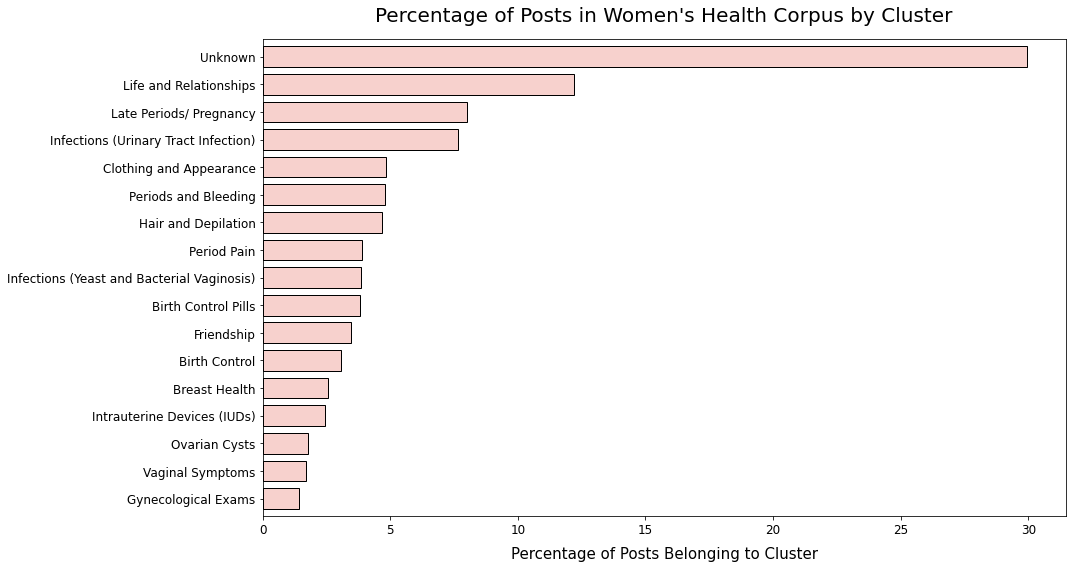

In [47]:
plot_topics_in_corpus(health, 
                      'kmeans_cluster', 
                       blush, 
                       title = "Percentage of Posts in Women\'s Health Corpus by Cluster",
                       x_label = 'Percentage of Posts Belonging to Cluster')

This figure illustrates that the K-Means Clustering algorithm was not effective at classifiying ~30% of documents (posts) in the corpus. The majority of posts belong to the a category that seemed to have very random terms and was difficult to interpret. 

### Fertility and Pregnancy Corpus

#### Get Words Associated with Cluster Centers

In [20]:
obsgyn_kmeans_topics = get_topic_terms_kmeans(obsgyn_kmeans, 15, obsgyn_terms)

#### Describe Clusters

<h4 align = center> Clusters Related to Health Concerns </h4>

|Cluster Number| Name| Top 5 Terms|
|:-:|:-:|:-:|
|0|Labor|contraction, labor, hour, CM (centimeters), epidural|
|1|Obstetrics Appointments| ultrasound, doctor, appointment, scan, blood|
|3| Pregnancy Status| pregnant, pregnancy, find, try, find pregnant|
|4| Fetal Movement and Development| baby, kick, thing, need, love|
|7| Weight and Nausea| eat, food, weight, gain, sickness|
|8| Symptoms of Pregnancy|pregnancy, symptom, pregnant, experience, early|
|10| Sleep| sleep, night, wake, hour, bed|
|11| Period and Pregnancy| period, test, start, late, pregnant|
|12| Ovulation| cycle, CD (cycle day), OPK (ovulation predictor kit), ovulation, ovulate|
|13| Pregnancy Tests| test, positive, pregnancy test, negative, pregnancy|
|14| Pain| pain, bad, hurt, experience, low|

<h4 align = center> Clusters Not Related to Health Concerns </h4>

|Cluster Number| Name| Top 5 Terms
|:-:|:-:|:-:|
|2| Gender Reveal| boy, girl, gender, baby, find|
|5| Pregnancy Announcement| work, tell, husband, family, baby|
|6| Baby Shower| shower, baby shower, baby, gift, friend|
|9| Unknown| try, help, look, start, birth|



#### Visualize Cluster Composition of Corpus

In [22]:
obsgyn['kmeans_cluster'] = obsgyn_kmeans.labels_

In [63]:
obsgyn['kmeans_cluster'] = obsgyn['kmeans_cluster'].map({
    0 : 'Labor',
    1 : 'Obstetrics Appointments',
    2 : 'Gender Reveal',
    3 : 'Pregnancy Status',
    4 : 'Fetal Movement and Development',
    5 : 'Pregnancy Announcement',
    6 : 'Baby Shower',
    7 : 'Weight and Nausea',
    8 : 'Symptoms of Pregnancy',
    9 : 'Unknown',
    10 : 'Sleep',
    11 : 'Period and Pregnancy',
    12 : 'Ovulation',
    13 : 'Pregnancy Tests',
    14 : 'Pain'
})

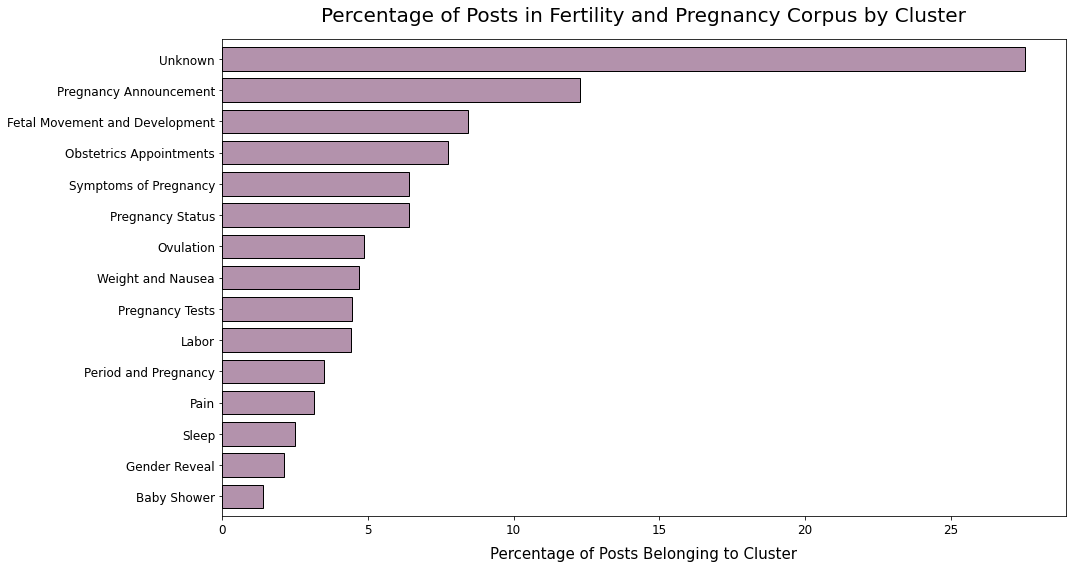

In [64]:
plot_topics_in_corpus(obsgyn, 
                      'kmeans_cluster', 
                       dark_purple, 
                       title = "Percentage of Posts in Fertility and Pregnancy Corpus by Cluster",
                       x_label = 'Percentage of Posts Belonging to Cluster')

## Conclusions